In [1]:
import numpy as np
from scipy.signal import find_peaks, czt
from scipy.stats import linregress, skew, kurtosis
from itertools import permutations


def compute_bvp_short_window_features(
    bvp,
    fs,
    fmin=0.66,
    fmax=3.0,
    n_czt_bins=512
):
    """
    Robust short-window (≈3s) BVP features for arousal classification.
    Designed for small manually labeled emotional segments.

    Parameters
    ----------
    bvp : np.ndarray
        1D BVP signal
    fs : float
        Sampling frequency (Hz)
    """

    features = {}
    bvp = np.asarray(bvp, dtype=float)

    if len(bvp) < fs * 2:  # too short
        return {k: np.nan for k in [
            "mean_hr", "hr_slope",
            "dom_freq", "peak_power_ratio",
            "spec_entropy", "freq_variance", "hr_snr",
            "amp_mean", "amp_std",
            "signal_energy", "signal_std",
            "skewness", "kurtosis",
            "sample_entropy", "perm_entropy",
            "peak_success_ratio"
        ]}

    # Remove DC
    bvp = bvp - np.mean(bvp)

    # --------------------------------------------------
    # 1. Peak detection
    # --------------------------------------------------
    min_dist = int(0.4 * fs)
    peaks, _ = find_peaks(bvp, distance=min_dist)

    if len(peaks) >= 2:
        ibi = np.diff(peaks) / fs
        hr = 60.0 / ibi
        features["mean_hr"] = np.mean(hr)

        t = np.arange(len(hr))
        features["hr_slope"] = linregress(t, hr).slope
    else:
        features["mean_hr"] = np.nan
        features["hr_slope"] = np.nan

    # --------------------------------------------------
    # 2. Spectral features (CZT)
    # --------------------------------------------------
    w = np.exp(-1j * 2 * np.pi * (fmax - fmin) / (n_czt_bins * fs))
    a = np.exp(1j * 2 * np.pi * fmin / fs)

    spectrum = czt(bvp, n_czt_bins, w, a)
    power = np.abs(spectrum) ** 2
    freqs = np.linspace(fmin, fmax, n_czt_bins)

    total_power = np.sum(power)

    if total_power > 0:
        idx_peak = np.argmax(power)
        dom_freq = freqs[idx_peak]

        features["dom_freq"] = dom_freq
        features["peak_power_ratio"] = power[idx_peak] / total_power

        p_norm = power / total_power
        features["spec_entropy"] = -np.sum(
            p_norm * np.log2(p_norm + 1e-12)
        )

        features["freq_variance"] = np.sum(
            power * (freqs - dom_freq) ** 2
        ) / total_power

        features["hr_snr"] = np.max(power) / (np.mean(power) + 1e-12)

    else:
        features["dom_freq"] = np.nan
        features["peak_power_ratio"] = np.nan
        features["spec_entropy"] = np.nan
        features["freq_variance"] = np.nan
        features["hr_snr"] = np.nan

    # --------------------------------------------------
    # 3. Pulse amplitude features
    # --------------------------------------------------
    troughs, _ = find_peaks(-bvp, distance=min_dist)
    n_beats = min(len(peaks), len(troughs))

    if n_beats > 0:
        amp = bvp[peaks[:n_beats]] - bvp[troughs[:n_beats]]
        features["amp_mean"] = np.mean(amp)
        features["amp_std"] = np.std(amp)
    else:
        features["amp_mean"] = np.nan
        features["amp_std"] = np.nan

    # --------------------------------------------------
    # 4. Signal statistics
    # --------------------------------------------------
    features["signal_energy"] = np.sum(bvp ** 2)
    features["signal_std"] = np.std(bvp)
    features["skewness"] = skew(bvp)
    features["kurtosis"] = kurtosis(bvp)

    # --------------------------------------------------
    # 5. Entropy features
    # --------------------------------------------------
    def sample_entropy(x, m=2, r=0.2):
        x = np.asarray(x)
        r *= np.std(x)
        N = len(x)

        if N < m + 2:
            return np.nan

        def _phi(m):
            x_m = np.array([x[i:i + m] for i in range(N - m)])
            C = np.sum(
                np.max(
                    np.abs(x_m[:, None] - x_m[None, :]), axis=2
                ) <= r,
                axis=0
            ) - 1
            return np.sum(C) / ((N - m) * (N - m - 1))

        return -np.log(_phi(m + 1) / _phi(m))

    try:
        features["sample_entropy"] = sample_entropy(bvp)
    except Exception:
        features["sample_entropy"] = np.nan

    def permutation_entropy(x, order=3, delay=1):
        x = np.asarray(x)
        perms = list(permutations(range(order)))
        counts = np.zeros(len(perms))

        for i in range(len(x) - delay * (order - 1)):
            pattern = x[i:i + delay * order:delay]
            idx = perms.index(tuple(np.argsort(pattern)))
            counts[idx] += 1

        p = counts / np.sum(counts)
        return -np.sum(p * np.log2(p + 1e-12))

    try:
        features["perm_entropy"] = permutation_entropy(bvp)
    except Exception:
        features["perm_entropy"] = np.nan

    # --------------------------------------------------
    # 6. Signal quality
    # --------------------------------------------------
    if not np.isnan(features["mean_hr"]):
        expected_beats = len(bvp) / fs * (features["mean_hr"] / 60.0)
        features["peak_success_ratio"] = (
            len(peaks) / expected_beats
            if expected_beats > 0 else np.nan
        )
    else:
        features["peak_success_ratio"] = np.nan

    return features


In [2]:
import numpy as np

def extract_window_reflect(bvp, start_idx, end_idx):
    """
    Extract window [start_idx, end_idx) with reflection padding.
    start_idx and end_idx are sample indices.
    """
    N = len(bvp)
    idx = np.arange(start_idx, end_idx)

    # reflect indices
    idx_reflect = np.where(
        idx < 0,
        -idx,                          # reflect left
        np.where(
            idx >= N,
            2*N - idx - 2,             # reflect right
            idx
        )
    )

    return bvp[idx_reflect]


In [19]:
def compute_features_at_second(bvp, fs, t_sec, window_size=5):
    win_len = int(window_size * fs)

    # Center window around t_sec
    center_idx = int(t_sec * fs)
    start_idx = center_idx - win_len // 2
    end_idx = start_idx + win_len

    window = extract_window_reflect(bvp, start_idx, end_idx)

    features = compute_bvp_short_window_features(window, fs)

    # Return as ordered feature vector
    return list(features.values())


In [20]:
bvp = np.load(f"../BVPs/Patient_1/Q9_1.npy")
fs = 60
t_sec = 0

feats = compute_features_at_second(bvp, fs, 0)

print(feats)
print(len(feats))


[69.93627490521901, 2.371541501976285, 1.1270841487279843, 0.0162773442675156, 7.461157686599484, 0.25760967272882096, 8.334000264967646, 0.2149349205656527, 0.10156946157954604, 2.0607239387123553, 0.08287991189490883, 0.7927356702050539, 0.20864875556987483, 0.4307053805593344, 1.437799793703196, 0.8579238754325259]
16


In [21]:
label_map = {
    "Q1": "Q1: ↑Arousal ↓Val",
    "Q2": "Q2: ↑Arousal -Val",
    "Q3": "Q3: ↑Arousal ↑Val",
    "Q4": "Q4: -Arousal ↓Val",
    "Q5": "Q5: -Arousal -Val",
    "Q6": "Q6: -Arousal ↑Val",
    "Q7": "Q7: ↓Arousal ↓Val",
    "Q8": "Q8: ↓Arousal -Val",
    "Q9": "Q9: ↓Arousal ↑Val",
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [22]:
import joblib

pipe = joblib.load("pipe_5s.joblib")

pipe.classes_

array(['Q1: ↑Arousal ↓Val', 'Q3: ↑Arousal ↑Val', 'Q5: -Arousal -Val',
       'Q7: ↓Arousal ↓Val', 'Q9: ↓Arousal ↑Val'], dtype='<U17')

In [24]:
X = list(feats)
#y = get_label("Q1_1")

X = np.asarray(X).reshape(1, -1)

print(X)

y = pipe.predict(X)
y_prob = pipe.predict_proba(X)

print(y)
print(y_prob)

[[6.99362749e+01 2.37154150e+00 1.12708415e+00 1.62773443e-02
  7.46115769e+00 2.57609673e-01 8.33400026e+00 2.14934921e-01
  1.01569462e-01 2.06072394e+00 8.28799119e-02 7.92735670e-01
  2.08648756e-01 4.30705381e-01 1.43779979e+00 8.57923875e-01]]
['Q3: ↑Arousal ↑Val']
[[0.12  0.355 0.165 0.15  0.21 ]]


In [31]:
def analyze_video_quadrant_probs(
    bvp,
    fs,
    pipe,
    window_size=8,
    hop=1,
    n_windows=8
):
    T = int(len(bvp) / fs)

    times = []
    probs = []

    for t_sec in range(T):
        X = compute_features_at_second(
            bvp,
            fs,
            t_sec,
        )

        if X is None:
            print("FATAL ERROR")
            continue
        
        X = list(X)

        X = np.asarray(X).reshape(1, -1)

        X = X.reshape(1, -1)   # IMPORTANT: 2D for sklearn
        p = pipe.predict_proba(X)[0]

        times.append(t_sec)
        probs.append(p)

    return {
        "time": np.array(times),
        "raw_probs": np.array(probs),
        "classes": pipe.classes_
    }


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quadrant_probabilities(time, raw_probs, class_labels):
    """
    time: (T,)
    raw_probs: (T, 4)
    class_labels: list or array of 4 class names (pipe.classes_)
    """

    plt.figure(figsize=(12, 6))

    for i, label in enumerate(class_labels):
        plt.plot(time, raw_probs[:, i], label=label)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Probability")
    plt.title("Quadrant Probabilities Over Time")
    # plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


In [32]:
bvp = np.load("../BVPs/Patient_3/Q7_2.npy")
fs = 60

results = analyze_video_quadrant_probs(
    bvp=bvp,
    fs=fs,
    pipe=pipe,
    window_size=8,
    hop=2,
    n_windows=4
)

print(results["raw_probs"].shape)


(57, 5)


In [33]:
print(results["raw_probs"][0])

[0.11 0.29 0.22 0.12 0.26]


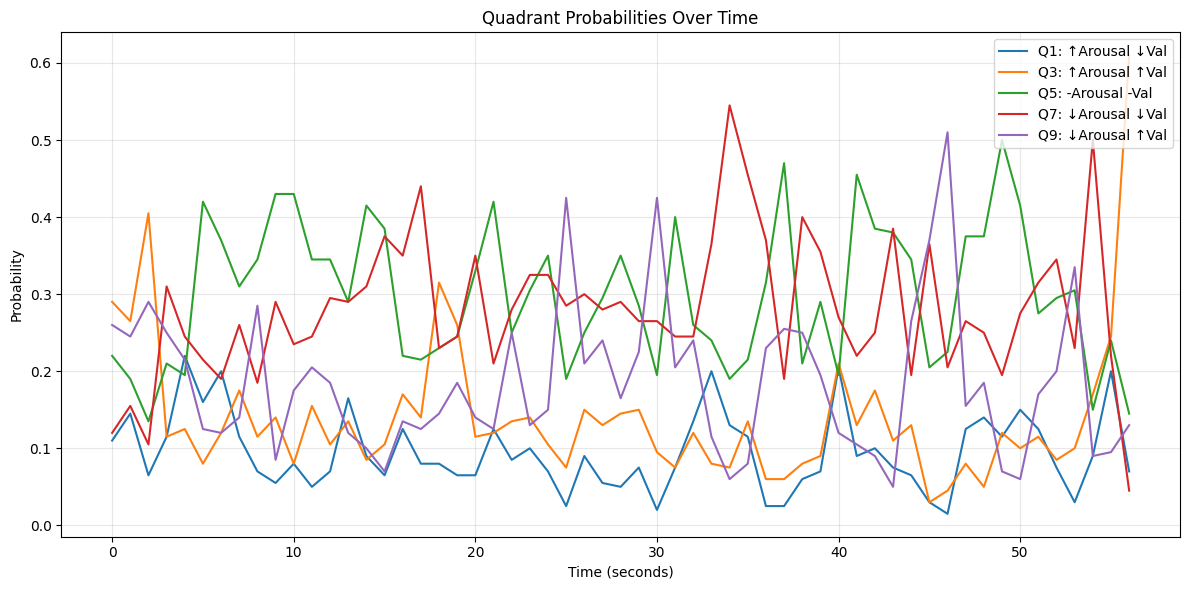

In [34]:
plot_quadrant_probabilities(
    time=results["time"],
    raw_probs=results["raw_probs"],
    class_labels=pipe.classes_
)
